In [1]:

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



In [2]:
# Read the dataframes

base_path = '/home/moein/Desktop/merganser-master/working_dir/csv_files/'
project_name = 'keras-team___keras'


repository_df = pd.read_csv(base_path + 'Repository_{}.csv'.format(project_name))
merge_scenario_df = pd.read_csv(base_path + 'Merge_Scenario_{}.csv'.format(project_name))
merge_replay_df = pd.read_csv(base_path + 'Merge_Replay_{}.csv'.format(project_name))
#related_commit_df = pd.read_csv(base_path + 'Conflicting_File_{}.csv'.format(project_name))
conflicting_file_df = pd.read_csv(base_path + 'Conflicting_File_{}.csv'.format(project_name))
conflicting_region_df = pd.read_csv(base_path + 'Conflicting_Region_{}.csv'.format(project_name))

repository_df.columns = ['id', 'update_date', 'name', 'descripton', 'language', 'watch_num', 'star_num', 'fork_num', 'issue_num', 'size', 'merge_scenario_num', 'is_done']
merge_scenario_df.columns = ['merge_commit_hash', 'ancestor_commit_hash', 'parent1_commit_hash', 'parent2_commit_hash', 'parallel_changed_file_num', 'merge_commit_can_compile', 'merge_commit_can_pass_test', 'ancestor_can_compile', 'ancestor_can_pass_test','parent1_can_compile', 'parent1_can_pass_test', 'parent2_can_compile', 'parent2_can_pass_test', 'merge_commit_date', 'ancestor_date', 'parent1_date', 'parent2_date', 'parent1_developer_num', 'parent2_developer_num', 'pull_request', 'repository_id']
merge_replay_df.columns = ['merge_technique', 'is_conflict', 'can_compile', ' can_pass_test', 'execution_time', 'result_is_equal_to_replay', 'Merge_Scenario_merge_commit_hash', 'Merge_scenario_Repository_id']
#related_commit_d.columns = []
conflicting_file_df.columns = ['file_path_name', 'conflict_type', 'Merge_Replay_merge_technique', 'Merge_Replay_Merge_Scenario_merge_commit_hash', 'Merge_Replay_Merge_Scenario_Repository_id']
conflicting_region_df.columns = ['parent1_path', 'parent2_path', 'parent1_name', 'parent2_name', 'parent1_start_line', 'parent1_length', 'parent2_start_line', 'parent2_lenght', 'parent1_code', 'parent2_code', 'Merge_Replay_merge_technique', 'Merge_Replay_Merge_Scenario_merge_commit_hash', 'Merge_Replay_Merge_Scenario_Repository_id']






In [3]:
# Basic stats

num_merge_scenario = len(merge_scenario_df)
num_conflicts = sum(merge_scenario_df.merge(merge_replay_df, left_on='merge_commit_hash', right_on='Merge_Scenario_merge_commit_hash')['is_conflict'].tolist())
rate_conflicts = num_merge_scenario / num_conflicts

print('# merge scenarios: {}'.format(num_merge_scenario))
print('# merge conflicts: {}'.format(num_conflicts))
print('% conflict rate: {:0.2f} %'.format(rate_conflicts))

# merge scenarios: 773
# merge conflicts: 70
% conflict rate: 11.04 %


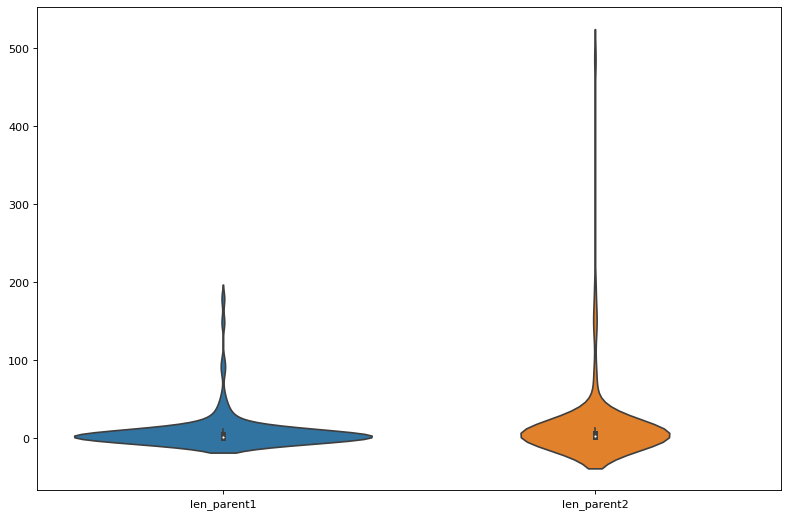

In [4]:
# Length of conflicts

figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

len_parent1 = conflicting_region_df['parent1_length'].tolist()
len_parent2 = conflicting_region_df['parent2_lenght'].tolist()

conflicts_len_df = pd.DataFrame(np.array([len_parent1, len_parent2]).T, columns=['len_parent1', 'len_parent2'])
sns.violinplot(data = conflicts_len_df) 
plt.show()

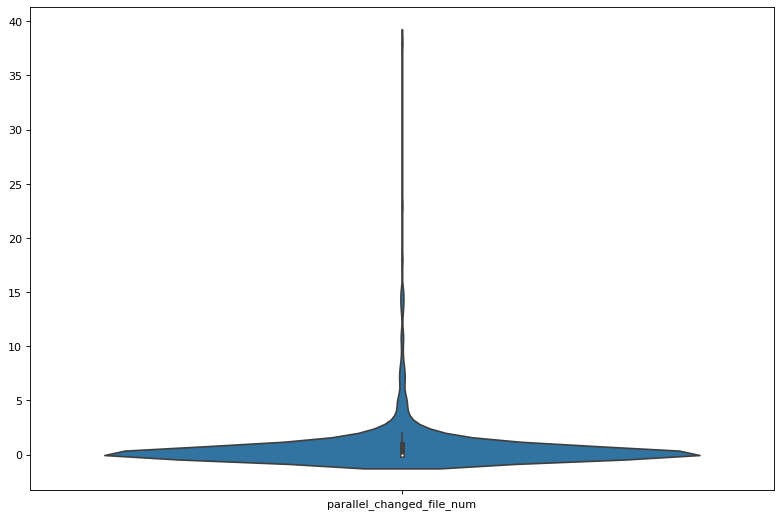

In [5]:
# Distribiotion of parallel changes

figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

parallel_changes = merge_scenario_df['parallel_changed_file_num'].tolist()

conflicts_len_df = pd.DataFrame(np.array([parallel_changes]).T, columns=['parallel_changed_file_num'])
sns.violinplot(data = conflicts_len_df) 
plt.show()

In [6]:
# Developers involved in conflicts

In [7]:
import keyword


def get_code_snippet_features(code: str):
    if isinstance(code, str) == False:
        return np.zeros((1, len(keyword.kwlist) + 2))
    feature_bow = [code.count(k) for k in keyword.kwlist]
    feature_line = [code.count('\n')]
    feature_token_num = [len(code.split())]
    return np.array(feature_bow + feature_line + feature_token_num)

#def get_code_features(code: list):
    
parent1_code_features = np.vstack([get_code_snippet_features(i) for i in conflicting_region_df['parent1_code'].tolist()])
parent2_code_features = np.vstack([get_code_snippet_features(i) for i in conflicting_region_df['parent2_code'].tolist()])

feature_code = np.hstack((parent1_code_features, parent2_code_features))


feature_names = ['keyword_' + i for i in keyword.kwlist] + ['line_num', 'token_num']
feature_names = ['parent1_' + i for i in feature_names] + ['parent2_' + i for i in feature_names]

In [8]:
len(feature_names)
feature_code.shape

(131, 70)

In [9]:
from sklearn.cluster import KMeans

cluster_labels = KMeans(n_clusters=2, random_state=0).fit(feature_code).labels_
cluster_names = [str(i) for i in set(cluster_labels)]



In [10]:
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

feature_code_2d = LocallyLinearEmbedding(n_components=2).fit_transform(feature_code)


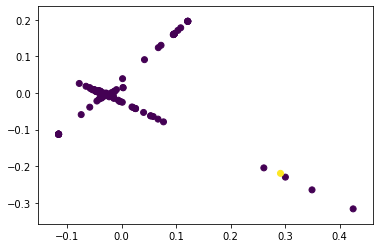

In [11]:
import matplotlib.pyplot as plt

plt.scatter(feature_code_2d[:, 0], feature_code_2d[:, 1], c=cluster_labels)
plt.show()

In [12]:
conflicting_region_df['cluster'] = cluster_labels
conflicting_region_df[['parent1_code', 'parent2_code', 'cluster']].to_csv('a.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


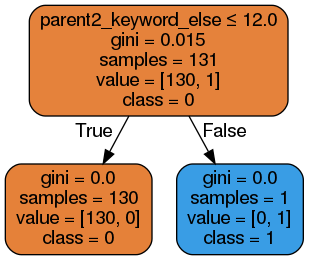

In [13]:


from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(feature_code, cluster_labels)



from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names, class_names=cluster_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())